In [2]:
library(tidyverse)
library(ggdendro)

### #Define dendrogram function genarating plot -----
dendro_data_k <- function(hc, k) {
  
  hcdata    <-  dendro_data(hc, type = "rectangle")
  seg       <-  hcdata$segments
  labclust  <-  cutree(hc, k)[hc$order]
  segclust  <-  rep(0L, nrow(seg))
  heights   <-  sort(hc$height, decreasing = TRUE)
  height    <-  mean(c(heights[k], heights[k - 1L]), na.rm = TRUE)
  
  for (i in 1:k) {
    xi      <-  hcdata$labels$x[labclust == i]
    idx1    <-  seg$x    >= min(xi) & seg$x    <= max(xi)
    idx2    <-  seg$xend >= min(xi) & seg$xend <= max(xi)
    idx3    <-  seg$yend < height
    idx     <-  idx1 & idx2 & idx3
    segclust[idx] <- i
  }
  
  idx                    <-  which(segclust == 0L)
  segclust[idx]          <-  segclust[idx + 1L]
  hcdata$segments$clust  <-  segclust
  hcdata$segments$line   <-  as.integer(segclust < 1L)
  hcdata$labels$clust    <-  labclust
  
  hcdata
}


In [4]:
### Heat map prepartion -----
#extract DEG from each result and filter genes for heatmap
Total <- read.csv("Total/select/Total_Maya2_root.csv")
WT_DEG <- Total %>%
  filter(Padj_WT < 0.1, abs(Log2FC_WT) > 1)
flg2_DEG <- Total %>%
  filter(Padj_fls2 < 0.1, abs(Log2FC_fls2) > 1)

rownames(WT_DEG) <- WT_DEG$Gene
rownames(flg2_DEG) <- flg2_DEG$Gene

ult_list <- c(rownames(WT_DEG), rownames(flg2_DEG))
length(ult_list)
ult_list <- unique(ult_list)
length(ult_list)

#list for Heatmap
Total_HM <- Total %>%
  dplyr::select(Gene, starts_with("Log2")) %>%
  dplyr::filter(Gene %in% ult_list)
write_csv(Total_HM,"Heatmap/select/Maya2_HM_input.csv")
HMinput <- Total_HM
rownames(HMinput)<-HMinput$Gene
HMinput$Gene<-NULL

#Cluster genes using hclust()
distance<-dist(HMinput, method='canberra')
model<-hclust(distance, method='complete', members=NULL)

#Reorder HMinput by the clustering and organize into ggplot-optimized form
HMinput$Gene<-rownames(HMinput)
HMinput$Gene<-factor(HMinput$Gene, levels=model$labels[model$order])
HMinput$Gene<-NULL
HMinput2<-HMinput %>% rownames_to_column() %>% gather(colname, value, -rowname)
HMinput2$value<-as.numeric(HMinput2$value)
HMinput2$rowname<-factor(HMinput2$rowname, levels=model$labels[model$order])

#The number designates number of clusters
ddata_2<-dendro_data_k(model, 3)


[1] 462

[1] 373

pdf 
  2

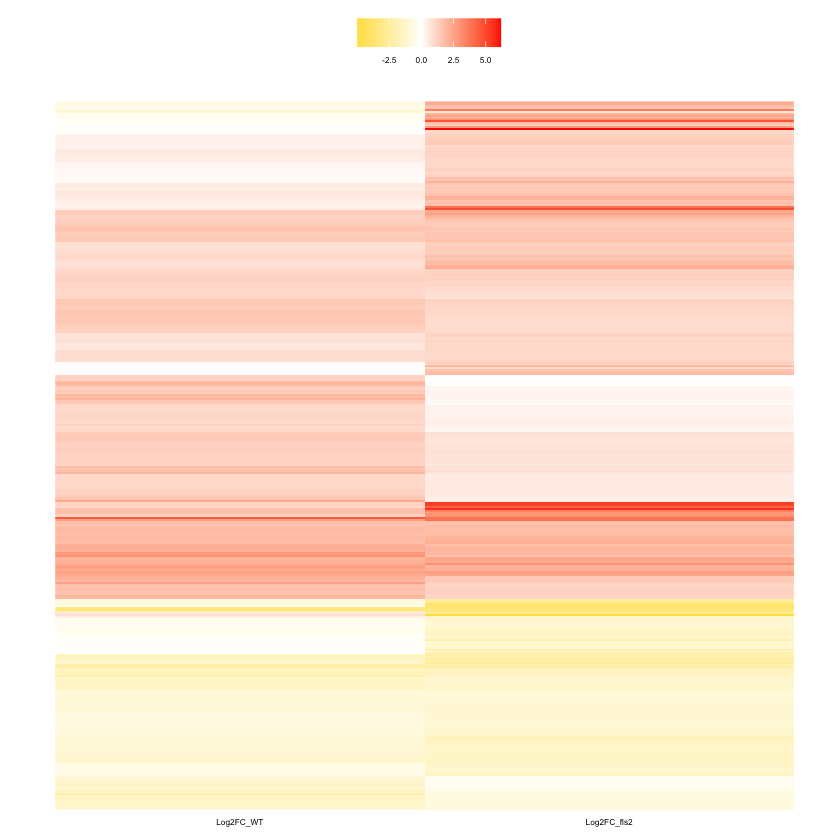

In [5]:
#Heatmap

heatmap <- "Heatmap/select/Maya2_Heatmap.tiff"
tiff(heatmap, width = 3, height = 10, res = 600, units = "cm")
ggplot(HMinput2, aes(x=colname, y=rowname, fill=value))+
  geom_raster()+ 
  scale_fill_gradient2(low='#ffda00', high='#ff2800')+
  scale_x_discrete(limits=c('Log2FC_WT','Log2FC_fls2'))+
  theme(panel.background = element_blank(),
        axis.text.x=element_text(angle=0, hjust=0.5,vjust=1, size=5, color='black'),
        axis.text.y=element_blank(),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.title=element_text(size=0),
        legend.title = element_text(size=0),
        legend.text = element_text(size=5, margin=unit(c(0.2,0.2,0.2,0.2), "cm")),
        legend.spacing.y = unit(2,"cm"),
        legend.direction = ("horizontal"),
        legend.position = ("top")
  )
dev.off()
ggplot(HMinput2, aes(x=colname, y=rowname, fill=value))+
  geom_raster()+ 
  scale_fill_gradient2(low='#ffda00', high='#ff2800')+
  scale_x_discrete(limits=c('Log2FC_WT','Log2FC_fls2'))+
  theme(panel.background = element_blank(),
        axis.text.x=element_text(angle=0, hjust=0.5,vjust=1, size=5, color='black'),
        axis.text.y=element_blank(),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.title=element_text(size=0),
        legend.title = element_text(size=0),
        legend.text = element_text(size=5, margin=unit(c(0.2,0.2,0.2,0.2), "cm")),
        legend.spacing.y = unit(2,"cm"),
        legend.direction = ("horizontal"),
        legend.position = ("top")
  )

pdf 
  2

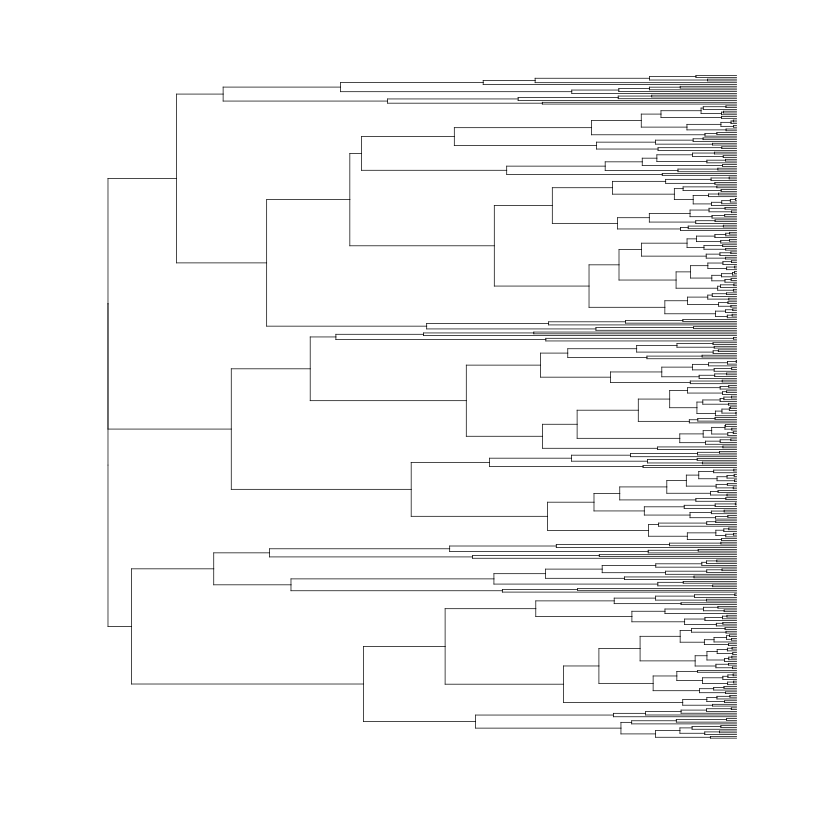

In [6]:
#Dendrogram
Dendro <- "Heatmap/select/Maya2_Dendrogram.tiff"
tiff(Dendro, width = 3, height = 10, res = 600, units = "cm")
ggplot()+geom_segment(data=segment(ddata_2), 
                      aes(x=x, y=y, xend=xend, yend=yend),
                      lineend="round", 
                      linewidth =0.2, 
                      show.legend=FALSE)+
  coord_flip()+
  scale_y_reverse(expand=c(0.1,0.1))+
  scale_x_continuous(expand=c(0.1,0.1))+
  theme_dendro()

dev.off()
ggplot()+geom_segment(data=segment(ddata_2), 
                      aes(x=x, y=y, xend=xend, yend=yend),
                      lineend="round", 
                      linewidth =0.2, 
                      show.legend=FALSE)+
  coord_flip()+
  scale_y_reverse(expand=c(0.1,0.1))+
  scale_x_continuous(expand=c(0.1,0.1))+
  theme_dendro()

In [7]:
### Get Cluster information -----
cluster <- as.data.frame(ddata_2$labels)
cluster <- cluster %>%
  dplyr::select(x, label, clust)
colnames(cluster) <- c("Order", "Gene", "clust")

cluster1 <- cluster %>%
  dplyr::filter(clust == 1)
cluster2 <- cluster %>%
  dplyr::filter(clust == 2)
cluster3 <- cluster %>%
  dplyr::filter(clust == 3)

Total_essential <- Total %>%
  dplyr::select(Gene, Gene_Symbol, Gene_Name, 
                Log2FC_WT, Padj_WT, Log2FC_fls2, Padj_fls2, GO) %>%
  dplyr::filter(Gene %in% ult_list)

Heatmap_final <- merge(Total_essential, cluster, by = "Gene")

Heatmap_final <- Heatmap_final %>%
  dplyr::arrange(desc(Order))

total_cluster1 <- Heatmap_final %>%
  dplyr::filter(Gene %in% cluster1$Gene)
total_cluster2 <- Heatmap_final %>%
  dplyr::filter(Gene %in% cluster2$Gene) 
total_cluster3 <- Heatmap_final %>%
  dplyr::filter(Gene %in% cluster3$Gene) 

num_rows1 <- nrow(total_cluster1)
print(num_rows1)
num_rows2 <- nrow(total_cluster2)
print(num_rows2)
num_rows3 <- nrow(total_cluster3)
print(num_rows3)

write.csv(Heatmap_final,"Heatmap/select/Maya2_Heatmap_cluster.csv")
write.csv(total_cluster1,"Heatmap/select/Maya2_cluster1.csv")
write.csv(total_cluster2,"Heatmap/select/Maya2_cluster2.csv")
write.csv(total_cluster3,"Heatmap/select/Maya2_cluster3.csv")

[1] 144
[1] 118
[1] 111


Warning message:
“Removed 510 rows containing missing values or values outside the scale range
(`geom_raster()`).”


pdf 
  2

Warning message:
“Removed 510 rows containing missing values or values outside the scale range
(`geom_raster()`).”


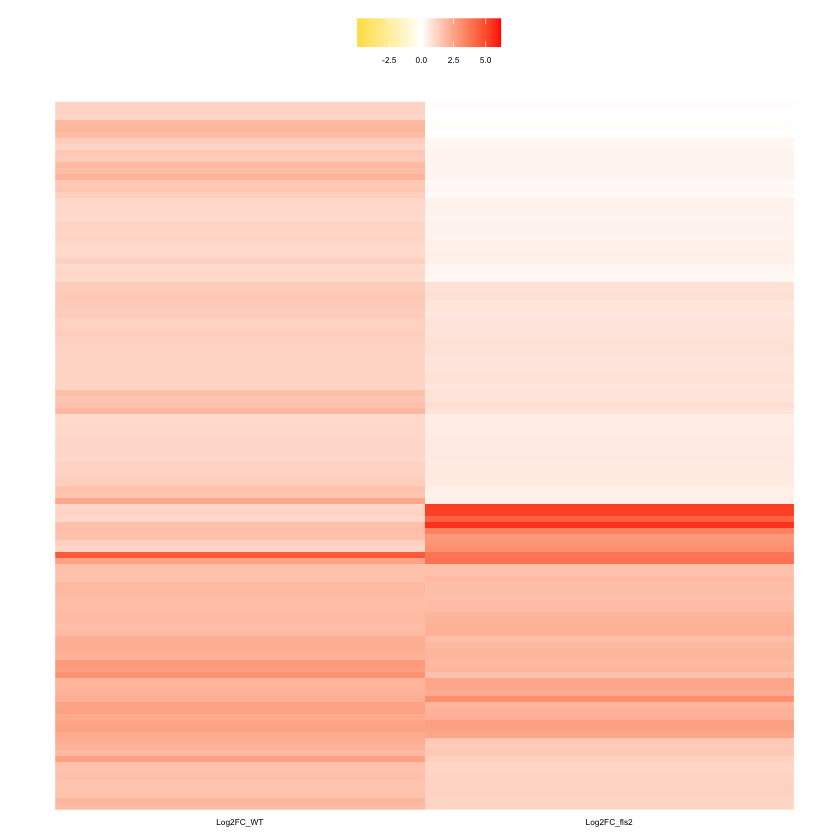

In [8]:
### Heatmap focus -----
#designate cluster gene
cls2 <- factor(cluster2$Gene)

#red:#ff2800, yellow:#ffda00 : green : #009300, magenta : #D5008E
#Heatmap
heatmap_cs2 <- "Heatmap/select/Maya2_Heatmap_cs2.tiff"
tiff(heatmap_cs2, width = 5, height = 10, res = 600, units = "cm")
ggplot(HMinput2, aes(x=colname, y=rowname, fill=value))+
  geom_raster()+ 
  scale_fill_gradient2(low='#ffda00', high='#ff2800')+
  scale_x_discrete(limits=c('Log2FC_WT','Log2FC_fls2'))+
  scale_y_discrete(limits=cls2)+
  theme(panel.background = element_blank(),
        axis.text.x=element_text(angle=0, hjust=0.5,vjust=1, size=5, color='black'),
        axis.text.y=element_blank(),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.title=element_text(size=0),
        legend.title = element_text(size=0),
        legend.text = element_text(size=5, margin=unit(c(0.2,0.2,0.2,0.2), "cm")),
        legend.spacing.y = unit(2,"cm"),
        legend.direction = ("horizontal"),
        legend.position = ("top")
  )

dev.off()
ggplot(HMinput2, aes(x=colname, y=rowname, fill=value))+
  geom_raster()+ 
  scale_fill_gradient2(low='#ffda00', high='#ff2800')+
  scale_x_discrete(limits=c('Log2FC_WT','Log2FC_fls2'))+
  scale_y_discrete(limits=cls2)+
  theme(panel.background = element_blank(),
        axis.text.x=element_text(angle=0, hjust=0.5,vjust=1, size=5, color='black'),
        axis.text.y=element_blank(),
        axis.ticks.x=element_blank(),
        axis.ticks.y=element_blank(),
        axis.title=element_text(size=0),
        legend.title = element_text(size=0),
        legend.text = element_text(size=5, margin=unit(c(0.2,0.2,0.2,0.2), "cm")),
        legend.spacing.y = unit(2,"cm"),
        legend.direction = ("horizontal"),
        legend.position = ("top")
  )